# Лабораторная работа 2: Использование численных методов в задачах оптимизации


---

Работу выполнили:

*   Кудрявцев Роман
*   Гончаренко Данила
*   Зыков Егор
*   Тарлецкий Александр

### 1.1 Реализация алгоритмов BFGS и L-BFGS

## 1. Поиск минимума функции:

$$
\begin{equation*}
f(x) = \frac{1}{2} \left[ (x_1)^2 + \sum_{i=1}^{2} (x_i - x_{i+1})^2 + (x_3)^2 \right] - x_1
\end{equation*}
$$

### Представление применимости алгоритмов BFGS и L-BFGS к данной оптимизационной задаче

Для того, чтобы алгоритм BFGS можно было применить к задаче оптимизации, функция должна быть дважды дифференцируемой на всей области определения $f(x)$ и выпуклой. Тогда по существующим определению (дважды дифф. функции) и критерию (ниже) достаточно будет вычислить матрицу вторых производных.

(Критерий выпуклости функции на основе $H(f)$) Если матрица Гессе $H(f)$ (матрица вторых производных) положительно (полу)определена, то функция f (строго) выпукла.

\begin{equation*}
\nabla f(x) =
\begin{bmatrix}
 2x_1-x_2-1 \\
 -x_1+2x_2-x_3 \\
 -x_2+2x_3 \\
\end{bmatrix}^T
\end{equation*}

\begin{equation*}
H(f) =
\begin{bmatrix}
 2 & -1 & 0 \\
 -1 & 2 & -1 \\
 0 & -1 & 2 \\
\end{bmatrix}
\end{equation*}

\begin{equation*}
\sigma_1 = 2 > 0
\end{equation*}

\begin{equation*}
\sigma_2 = \left| \begin{matrix} 2 & -1 \\ -1 & 2 \end{matrix} \right| = 3 > 0
\end{equation*}

\begin{equation*}
\sigma_3 = 2 \cdot \left| \begin{matrix} 2 & -1 \\ -1 & 2 \end{matrix} \right| + \left| \begin{matrix} -1 & -1 \\ 0 & 2 \end{matrix} \right| = 6 - 2 = 4 > 0
\end{equation*}

In [ ]:
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
import scipy, time
from scipy.special import expit
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Изменим вид исходной функции:

$f(x) = \frac{1}{2} \left[ (x_1)^2 + \sum_{i=1}^{2} (x_i - x_{i+1})^2 + (x_3)^2 \right] - x_1 = x_1^2 + x_2^2 + x_3^2 - x_1 - x_1x_2 - x_2x_3$

In [ ]:
def f(x):
    return x[0]**2 + x[1]**2 + x[2]**2 - x[0] - x[0]*x[1] - x[1]*x[2]

Аналитическое определение градиента:

In [ ]:
def anal_graf(f, x):
    dfdx1 = 2 * x[0] - x[1] - 1
    dfdx2 = 2 * x[1] - x[0] - x[2]
    dfdx3 = 2 * x[2] - x[1]
    return np.array([dfdx1, dfdx2, dfdx3])

Численное определение гардиента:


In [ ]:
def num_graf(f, x, h=1e-5):
    ngrad = np.zeros_like(x)
    for i in range(len(x)):
        h_e = np.zeros_like(x)
        h_e[i] = h
        ngrad[i] = (f(x + h_e) - f(x - h_e)) / (2 * h)
    return ngrad

Очевидно, что если есть возможность аналитически вычислить градиент, то это следует делать. Но не всегда функция представлена явно, а методы оптимизации применять необходимо. В таких случаях приходится прибегать к численному приближению градиента. Возникает вопрос: насколько точным будет такое приближение? Давайте возьмём несколько точек, вычислим градиент аналитически и с помощью конечно-разностной аппроксимации, а затем сравним результаты по средней абсолютной ошибке.

In [ ]:
f_points = 50

x1 = np.linspace(-1, 1, f_points)
x2 = np.linspace(1, 3, f_points)
x3 = np.linspace(-3, -1, f_points)

points = np.array(list(zip(x1, x2, x3)))

mean_abs_er = np.mean([
    np.abs(num_graf(f, points[i]) - anal_graf(f, points[i]))
    for i in range(f_points)
])

print(f'Mean absolute error is {mean_abs_er}')

Mean absolute error is 6.128308231249472e-11


Таким образом, при достаточно малых изменениях аргумента численное приближение может успешно заменить аналитическое вычисление. Особенно это важно в ситуациях, когда невозможно найти градиент аналитически, а численное приближение необходимо применить.
Теперь перейдем к нахождению минимума функции, используя то
определение градиента, которое доступно.
Для вычисления приближаемого решения используется соотношение $\mathbf{x}_{k+1} = x_k + a_kp_k$, где $a_k$ задает шаг обновления, который должен
удовлетворять условиям Вольфе. Для чего это необходимо?

В первую очередь, недостаточно условия $f(x_k + a_kp_k) < f(k)$.
Это наглядно демонстрирует пример: $f^* = -1$, но $f_k = 1/k$, где $\lim_{k ⟶ inf} {f_k}=0$.

Так же нам необходимо учитывать градиент. Если его значение не равно нулю, то он может способствовать уменьшению функции от текущей точки. Проследим за тем, чтобы следующее значение уменьшалось с учетом вклада градиента:
1.  $f(x_k + a_kp_k) \leq f(x_k) + c_1a_k\nabla f_k^Tp_k$

Значений $a_k$, удовлетворяющих первому условию, может быть много. Чтобы добиться максимального уменьшения функции, следует дополнительно потребовать, чтобы градиент в следующей точке был меньше по наклону, чем в текущей. Это логично, поскольку уменьшение наклона приближает к оптимальному значению.
2.  $\left| \nabla f(x_k + a_kp_k)^T p_k \right| \leq c_2\left| \nabla f_k^T p_k \right|$

Направление поиска $p_k$ определяется в зависимости от выбранного метода оптимизации. Это может быть простой градиентный спуск или методы второго порядка, такие как ньютоновские или квазиньютоновские. Метод BFGS и его улучшенная версия L-BFGS относятся к методам второго порядка, поэтому направление поиска задаётся как $p_k = [\nabla f_k^2]^{-1} \nabla f_k$

Условия 1 и 2 называются усиленными условиями Вольфе (когда нам были даны "обычные" (без слова "усиленные") условия Вольфе). Далее мы их и использовали. Источник: Wolfe, P. "Convergence Conditions for Ascent Methods" (1969), "Convergence Conditions for Ascent Methods. II: Some Corrections" (1971)

In [ ]:
def zoom_wolf(f, num_graf, x, p, a_lo, a_hi, c1 = 1e-4, c2 = 0.9, eps = 1e-4):
    phi = lambda a: f(x + a*p)
    while True:
        a = (a_lo + a_hi) / 2
        if np.abs(a_hi - a_lo) < eps:
            return

        if phi(a) > phi(0) + c1 * a * num_graf(f,x).T @ p or phi(a) >= phi(a_lo):
            a_hi = a
        else:
            ngrad = num_graf(f, x + a * p)
            if np.abs(ngrad.T @ p) <= c2 * np.abs(num_graf(f,x).T @ p):
                return a
            if ngrad.T @ p * (a_hi - a_lo) >= 0.0:
                a_hi = a_lo

            a_lo = a

def search_wolf(f, num_graf, x, p, c1 = 1e-4, c2 = 0.9, a_max = 1e5):
    a0 = 0.0
    a1 = (a0 + a_max)/2
    phi = lambda a: f(x+a*p)

    while True:
        if phi(a1) > phi(0) + c1 * a1 * num_graf(f, x).T @ p or phi(a1) >= phi(a0):
            return zoom_wolf(f, num_graf, x, p, a0, a1)

        ngrad = num_graf(f, x + a1 * p)
        if np.abs(ngrad.T @ p) <= c2 * np.abs(num_graf(f,x).T @ p):
            return a1
        if ngrad.T @ p >= 0.0:
            return zoom_wolf(f, num_graf, x, p, a1, a0)

        a0 = a1
        a1 = (a1 + a_max) / 2

### 1.2 Реализация алгоритма BFGS

В стандартной версии алгоритма обновление Гессиана происходит последующей формуле:

$H_{k+1} = (I - p_k s_k y_k^T)H_k(I - p_k y_k s_k^T) + p_k s_k s_k^T$, где $p_k = \frac{1}{y_k^T s_k}$

Это значит, что на каждой итерации алгоритма происходит полное обновление Гессиана (приближенное). В связи с этим, при обработке большого обЪёма данных работа алгоритма значительно замедляется.

In [ ]:
def hes(f, H, x0, x1):
    I = np.eye(len(x0))
    s = x1 - x0
    y = num_graf(f, x1) - num_graf(f, x0)
    p = 1. / (y.T @ s)

    m = p * (s[:, np.newaxis] @ y[np.newaxis, :])
    n = p * (y[:, np.newaxis] @ s[np.newaxis, :])
    k = p * (s[:, np.newaxis] @ s[np.newaxis, :])

    H = (I - m) @ H @ (I - n) + k
    return H

In [ ]:
def bfgs(f, x0, num_graf = num_graf, step_searcher = search_wolf, epsilon = 1e-9, max_iter = 100):
    k = 0
    H = np.eye(len(x0))
    ngrad = num_graf(f, x0)

    log = []
    while np.linalg.norm(ngrad) > epsilon and k < max_iter:
        p = -(H @ ngrad)
        a = step_searcher(f, num_graf, x0, p)
        if not a:
            break
        x1 = x0 + a * p
        H = hes(f, H, x0, x1)
        x0 = x1
        ngrad = num_graf(f, x0)

        log.append(f(x0))
        k += 1

    return x0, log

Для нахождения величины шага применяется линейный поиск, который удовлетворяет условиям Вольфе. Ранее были приведены аргументы, объясняющие целесообразность такого подхода. Далее рассмотрим, как изменяется сходимость при различных значениях шага.








In [ ]:
x, xlog = bfgs(f, np.random.rand(3), num_graf = num_graf, step_searcher = search_wolf)

Добавим несколько параметров с неизменным шагом и случайным поиском

In [ ]:
def step_rand(f, num_graf, x, p):
    return np.random.rand()

def step_const_0(f, num_graf, x, p):
    return 0.01

def step_const_1(f, num_graf, x, p):
    return 0.1

def step_const_2(f, num_graf, x, p):
    return 0.8

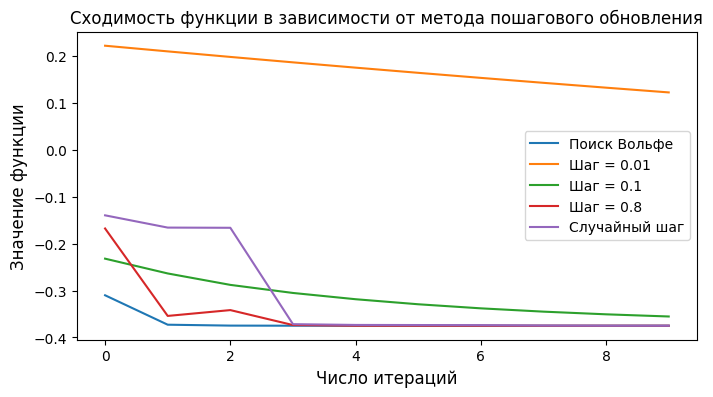

In [ ]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(xlog[:10], label = "Поиск Вольфе")

steps = {
    'Шаг = 0.01': step_const_0,
    'Шаг = 0.1': step_const_1,
    'Шаг = 0.8': step_const_2,
    'Случайный шаг': step_rand
}

for name, func in steps.items():
    y, ylog = bfgs(f, np.random.rand(3), num_graf= num_graf, step_searcher= func)
    ax.plot(ylog[:10], label = name)

ax.set_title('Сходимость функции в зависимости от метода пошагового обновления')
ax.set_xlabel('Число итераций', fontsize = 12)
ax.set_ylabel('Значение функции', fontsize = 12)

plt.legend()
plt.show()

Таким образом шаг обновления, задаваемый согласно условиям Вольфе,
помогает не просто сходиться (в примере сходимость есть в любом случае,
но при константном шаге вообще говоря может не достигаться, см. контпример из блока про условия Вольфе), но и делает это за меньшее число итераций.

### 1.3 Реализация алгоритма L-BFGS

Чтобы решить проблему работы с большими матрицами была разработана упрощённая версия алгоритма — L-BFGS (limited memory BFGS). Главное отличие этой версии в том, что на каждой итерации функция поиска направления не пересчитывает весь Гессиан. Вместо этого его оценивают, используя заранее определённое количество пар векторов $\left\{s_i, y_i \right\}$.

Количество рекомендованных пар к использованию $m = 3.. 20$.

In [ ]:
def two_loop_rec(ngrad, Hk0, vectors, ro, j, m):
    q = ngrad
    alphas = []

    for pair in vectors:
        alpha = pair[2] * (pair[0].T @ q)
        q = q - alpha * pair[1]
        alphas.append(alpha)

    r = Hk0 @ q

    for (pair, alpha) in zip(reversed(vectors), reversed(alphas)):
        beta = pair[2] * (pair[1].T @ r)
        r += pair[0] * (alpha - beta)

    return -r

In [ ]:
def l_bfgs(f, x0, num_graf = num_graf, epsilon = 1e-9, max_iter = 100, m = 10):
    k = 0
    vector_pairs = []
    ngrad = num_graf(f, x0)
    n = np.shape(ngrad)[0]
    s = np.concatenate((np.array([1]), np.zeros(n - 1, dtype=int)))
    y = np.concatenate((np.array([1]), np.zeros(n - 1, dtype=int)))
    p = 1 / (s.T @ y)
    vector_pairs.append((s, y, p))
    I = np.eye(n)

    log = []

    while np.linalg.norm(ngrad) > epsilon and k < max_iter:
        gamma = (s.T @ y) / (y.T @ y)
        H = gamma * I
        p = two_loop_rec(ngrad, H, vector_pairs, p, k, m)
        a = search_wolf(f, num_graf, x0, p)
        if not a:
            break
        x1 = x0 + a * p

        if k > m:
            vector_pairs.pop(0)

        s = x1 - x0
        y = num_graf(f, x1) - num_graf(f, x0)
        p = 1. / (y.T @ s)
        x0 = x1

        vector_pairs.append((s, y, p))

        ngrad = num_graf(f, x0)

        log.append(f(x0))
        k+= 1

    return x0, log

### 1.4 Сравнение алгоритмов BFGS и L-BFGS

Будем сравнивать алгоритмы по времени выполнения и величине ошибки после обучения.

Для L-BFGS вариативным параметром будет выступать количество сохраняемых пар векторов.

In [ ]:
def get_stat(optimizer, f, num_graf, n_experiments = 100, m = 10):
    times, xs = [], []
    for i in range(n_experiments):
        x0 = np.random.rand(3)
        start_time = time.time()
        x, logs = optimizer(f, x0, num_graf = num_graf)
        times.append(time.time() - start_time)
        xs.append(x)

    return np.mean(times), np.mean(xs, axis = 0)

def report(a, t, x):
    print(f"Среднее время выполнения {a} = {t}ms. Средний минимум {x}")

Запустим несколько экспериментов и сравним характеристики

In [ ]:
t1, x1 = get_stat(bfgs, f, num_graf)
t2, x2 = get_stat(l_bfgs, f, num_graf, m = 10)
t3, x3 = get_stat(l_bfgs, f, num_graf, m = 5)
t4, x4 = get_stat(l_bfgs, f, num_graf, m = 3)
t5, x5 = get_stat(l_bfgs, f, num_graf, m = 1)

In [ ]:
report("BFGS", t1, x1)
report("L-BFGS", t2, x2)
report("L-BFGS", t3, x3)
report("L-BFGS", t4, x4)
report("L-BFGS", t5, x5)

Среднее время выполнения BFGS = 0.025964252948760987ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.0482629656791687ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.030750067234039308ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.031260092258453366ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.030582706928253173ms. Средний минимум [0.75 0.5  0.25]


Для всех алгоритмов полученные минимумы совпали. Можно заметить, что обычный BFGS работает быстрее. Однако этот вывод справедлив только для данной функции, и в других случаях результат может быть иным.

Посмотрим такой же отчёт при градиенте, заданном аналитически

In [ ]:
t1, x1 = get_stat(bfgs, f, anal_graf)
t2, x2 = get_stat(l_bfgs, f, anal_graf, m = 10)
t3, x3 = get_stat(l_bfgs, f, anal_graf, m = 5)
t4, x4 = get_stat(l_bfgs, f, anal_graf, m = 3)
t5, x5 = get_stat(l_bfgs, f, anal_graf, m = 1)

In [ ]:
report("BFGS", t1, x1)
report("L-BFGS", t2, x2)
report("L-BFGS", t3, x3)
report("L-BFGS", t4, x4)
report("L-BFGS", t5, x5)

Среднее время выполнения BFGS = 0.012031152248382568ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.013978271484375ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.013329193592071534ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.013012959957122802ms. Средний минимум [0.75 0.5  0.25]
Среднее время выполнения L-BFGS = 0.015133409500122071ms. Средний минимум [0.75 0.5  0.25]


При работе алгоритма с градиентом, заданным аналитически, время выполнения уменьшилось.

## 2. Практическое применение: использование метода оптимизации L-BFGS для решения задачи логистической регрессии

### Представление набора данных

In [ ]:
X, y = make_classification(n_samples=500, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, train_size= 0.67, random_state= 42)

### Реализация оптимизатора Adam с численным приближением градиентов

In [ ]:
def adam_optimizer(f, w_init, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-9, max_iter=100):
    """
    :param f: Функция потерь, принимающая веса и возвращающая скалярную величину.
    :param w_init: Начальные веса (numpy массив).
    :param learning_rate: Скорость обучения.
    :param beta1: Параметр beta1 для моментов.
    :param beta2: Параметр beta2 для моментов.
    :param epsilon: Маленькое число для предотвращения деления на ноль.
    :param max_iter: Максимальное количество итераций.
    :return: Оптимизированные веса и лог значений функции потерь.
    """
    w = w_init.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    log = []
    for t in range(1, max_iter + 1):
        grad = np.zeros_like(w)
        h = 1e-5
        for i in range(len(w)):
            w_plus = w.copy()
            w_minus = w.copy()
            w_plus[i] += h
            w_minus[i] -= h
            grad[i] = (f(w_plus) - f(w_minus)) / (2 * h)

        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        w -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        loss = f(w)
        log.append(loss)

        if np.linalg.norm(grad) < 1e-6:
            break
    return w, log

### Реализация логической регрессии

In [ ]:
class LogRegression:
    def __init__(self, n_features, optimizer = bfgs, loss = log_loss):
        self.n_features = n_features
        self.w_b = np.random.rand(n_features + 1)
        self.optimizer = optimizer
        self.loss = loss

    def forward(self, data, w_b = None):
        if type(w_b) is not np.ndarray:
            w_b = self.w_b
        return expit(np.dot(data, w_b[:-1]) + w_b[-1])

    def train(self, data, labels):
        f = lambda w_b: self.loss(labels, self.forward(data, w_b))
        w_b, log = self.optimizer(f, self.w_b)
        self.log = log
        self.w_b = w_b
        return

### Сравнение характеристик работы алгоритмов

In [ ]:
bfgs_model = LogRegression(n_features= X.shape[1], optimizer=bfgs)
lbfgs_model = LogRegression(n_features=X.shape[1], optimizer=l_bfgs)
adam_model = LogRegression(n_features=X.shape[1], optimizer=adam_optimizer)

### Сравнение времени обучения

In [ ]:
%%time
bfgs_model.train(X_train, y_train)

CPU times: user 25.5 s, sys: 98.3 ms, total: 25.6 s
Wall time: 25.9 s


In [ ]:
%%time
lbfgs_model.train(X_train, y_train)

CPU times: user 22 s, sys: 69.8 ms, total: 22 s
Wall time: 22.1 s


In [ ]:
%%time
adam_model.train(X_train, y_train)

CPU times: user 2.82 s, sys: 13.8 ms, total: 2.83 s
Wall time: 2.83 s


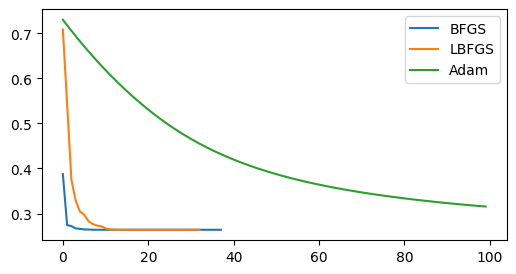

In [ ]:
fig, ax = plt.subplots(figsize = (6, 3))

ax.plot(bfgs_model.log, label = "BFGS")
ax.plot(lbfgs_model.log, label = "LBFGS")
ax.plot(adam_model.log, label = "Adam")

ax.legend()
plt.show()

На графике изображена зависимость ошибки от количества итераций. Можно заметить, что алгоритм L-BFGS сходится быстрее стандартного BFGS и кроме того требует меньше времени на обучение.

### Сравнение величины ошибки

Значение ошибки после обучения с BFGS:

In [ ]:
log_loss(y_test, bfgs_model.forward(X_test))


0.3211677045815759

Значение ошибки после обучения с L-BFGS:



In [ ]:
log_loss(y_test, lbfgs_model.forward(X_test))

0.3211677034778674

Значение ошибки после обучения с Adam:

In [ ]:
log_loss(y_test, adam_model.forward(X_test))

0.33304105102428627

Реализация через LogRegressor:

In [ ]:
sas = LogisticRegression().fit(X_train, y_train)
log_loss(y_test, sas.predict_proba(X_test))

0.31525186388257326

В итоге получается, что логистическая регрессия, оптимизированная при помощи BFGS, L-BFGS, Adam незначительно уcтупает библиотечной по качеству оптимизации.
